# Data Handling

Import Libraries

In [39]:
import pandas as pd
import networkx as nx
import glob
import matplotlib.pylab as plt
%matplotlib inline

### Load data and create a graph

In [2]:
addresses = pd.read_csv("data/Addresses.csv", low_memory=False)
entities = pd.read_csv("data/Entities.csv", low_memory=False)
intermediaries = pd.read_csv("data/Intermediaries.csv", low_memory=False)
offi = pd.read_csv("data/Officers.csv", low_memory=False)
edges = pd.read_csv("data/all_edges.csv", low_memory=False)

In [ ]:
G = nx.DiGraph()
for n,row in addresses.iterrows():
    G.add_node(row.node_id, node_type="address", details=row.to_dict())
    
for n,row in entities.iterrows():
    G.add_node(row.node_id, node_type="entities", details=row.to_dict())
    
for n,row in intermediaries.iterrows():
    G.add_node(row.node_id, node_type="intermediates", details=row.to_dict())
    
for n,row in offi.iterrows():
    G.add_node(row.node_id, node_type="officers", details=row.to_dict())
    
for n,row in edges.iterrows():
    G.add_edge(row.node_1, row.node_2, rel_type=row.rel_type, details={})

Write the adjacency locally for faster loading

In [ ]:
nx.write_adjlist(G,"fullgraph.adjlist")

### Computing some basic measures
We use two versions of the graph - a Directed, and an Undirected version, out of which we find thee following measures for every node -
1. in degree
2. out degree
3. recriprocity
4. rich club coefficient ( average degree, average 'officer degree' )
5. modularity ( ego networks )
6. cyclic coefficient
7. label count for neighbors
8. clustering coefficient
9. page rank
10. average neighbor degree

## TO-DO
1. Motifs
2. Motifs of Neighbors
3. Hierarchial Measures
4. Radiality Centrality
5. Functions of above said parameters to incorporate correlations?
6. Should we create subgraphs of each node and compute measures that are meant for full graphs?

### Read as a Directed Graph

In [ ]:
G = nx.read_adjlist("../../fullgraphs/fullgraph.adjlist",  create_using=nx.DiGraph())

### In Degree

In [ ]:
print "Calculating In Degree"
in_deg = G.in_degree()

print "Writing to file "
f = open( "../../results/in_degree.csv", 'wt' )
writer = csv.writer(f)
writer.writerow( ("node_id", "in_degree") )
for key in in_deg.keys():
    writer.writerow( ( key, in_deg[key] ) )
f.close()

### Out Degree

In [ ]:
print "Calculating Out Degree"
out_deg = G.out_degree()

print "Writing to file "
f = open( "../../results/out_degree.csv", 'wt' )
writer = csv.writer(f)
writer.writerow( ("node_id", "out_degree") )
for key in out_deg.keys():
    writer.writerow( ( key, out_deg[key] ) )
f.close()

### Reciprocity

In [ ]:
def reciprocity(G):
    recip = defaultdict(float)
    for node in G.nodes():
        pred = set(G.predecessors(node))
        succ = set(G.successors(node))
        overlap = pred & succ
        n_total = len(pred) + len(succ)

        # Reciprocity is not defined for isolated nodes.
        # Return None.
        if n_total == 0:
            recip[node] = -1
        else:
            reciprocity = 2.0*float(len(overlap))/float(n_total)
            recip[node] = reciprocity
    return recip

print "Calculating Reciprocity"
recip = reciprocity(G)

print "Writing to file "
f = open( "../../results/reciprocity.csv", 'wt' )
writer = csv.writer(f)
writer.writerow( ("node_id", "reciprocity") )
for key in recip.keys():
    writer.writerow( ( key, recip[key] ) )
f.close()

### Read as an Undirected Graph

### Clustering Coefficient

In [ ]:
print "Computing clustering"
bc = nx.clustering( G )

print "Writing to file "
with open('../../results/clustering_coefficient.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in bc.items()]

### Page Rank

In [ ]:
print "Calculating page rank"
pr = nx.pagerank_scipy(G)

print "Writing to file "
f = open( "../../results/page_rank.csv", 'wt' )
writer = csv.writer(f)
writer.writerow( ("node_id", "page_rank") )
for key in pr.keys():
    writer.writerow( ( key, pr[key] ) )
f.close()

### Average Neighbor Degree

In [ ]:
print "Computing average neighbour degree"
nd = nx.average_neighbor_degree( G )

print "Writing to file "
with open('../../results/average_neighbour_degree.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in nd.items()]

### Combining measures into a feature matrix

In [ ]:
path ='../../results' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
cnt = 1
for file_ in allFiles:
    print file_
    df = pd.read_csv(file_,index_col=None, header=0)
    if cnt != 1:
        del df['id']
    cnt += 1
    print df.head()
    list_.append(df)
frame = pd.concat(list_, axis=1)
print frame.head()
frame.to_csv("../../results/ensemble.csv", separator=',', index=False)
print "Done"

### Adding labels to the feature matrix

In [ ]:
with open('../../fullgraphs/all_nodes_type.json') as data_file:
    data = json.load(data_file)

print "Done loading Json"

df = pd.read_csv('../../results/ensemble.csv',index_col=None, header=0)
lst = df['id']
labels = []

print "started reading"
for i in range(len(lst)):
    labels.append(data[str(lst[i])]['node_type'])
print "completed"

se = pd.Series(labels)
df['label'] = se.values
df.to_csv('../../ensemble.csv', separator=',', index=False)

print "Done"

## Exploring the data

In [6]:
df = pd.read_csv("ensemble.csv") 
df.head()

,id,rec,page_rank,avg_neighbour_deg,cc,out,in_deg,label
0,287144,0.0,3.139258e-06,3.5,0.0,0,10,address
1,287145,0.0,8.378010e-07,3.0,0.0,0,1,address
2,287146,0.0,8.378010e-07,3.0,0.0,0,1,address
3,287147,0.0,9.740000e-07,2.0,0.0,0,1,address
4,287140,0.0,9.740000e-07,2.0,0.0,0,1,address


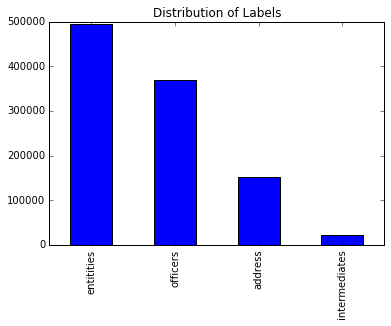

In [9]:
# plots a bar graph of label frequency.               
df.label.value_counts().plot(kind='bar')
# puts a title on our graph
plt.title("Distribution of Labels")

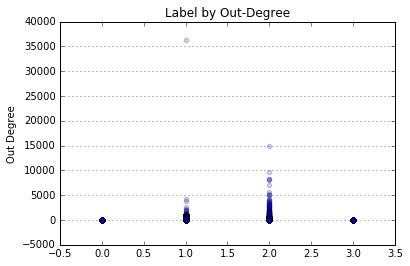

In [33]:
dict = {'entitities': 0, 'officers': 1, 'intermediates': 2, 'address': 3 }
def nodetypeinput( label ):
    return dict[label]
df['nodetype'] = df['label'].apply(nodetypeinput)
plt.scatter(df.nodetype, df.out, alpha=0.2)
# sets the y axis lable
plt.ylabel("Out Degree")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Label by Out-Degree")

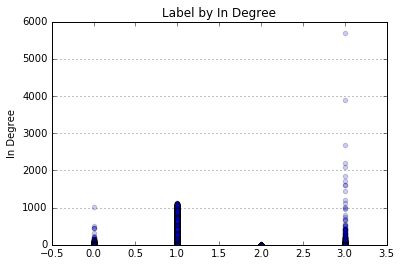

In [35]:
plt.scatter(df.nodetype, df.in_deg, alpha=0.2)
# sets the y axis lable
plt.ylabel("In Degree")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.ylim([0, 6000])
plt.title("Label by In Degree")

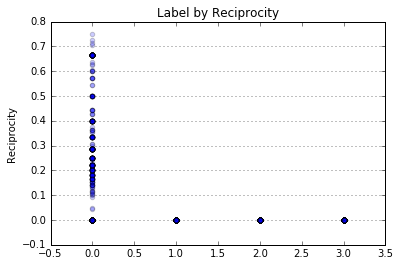

In [36]:
plt.scatter(df.nodetype, df.rec, alpha=0.2)
# sets the y axis lable
plt.ylabel("Reciprocity")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Label by Reciprocity")

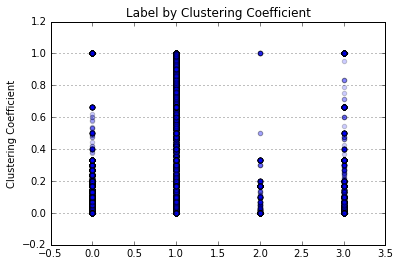

In [40]:
plt.scatter(df.nodetype, df.cc, alpha=0.2)
# sets the y axis lable
plt.ylabel("Clustering Coefficient")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Label by Clustering Coefficient")

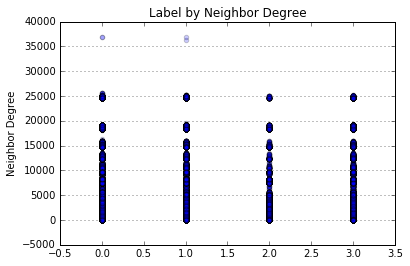

In [41]:
plt.scatter(df.nodetype, df.avg_neighbour_deg, alpha=0.2)
# sets the y axis lable
plt.ylabel("Neighbor Degree")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Label by Neighbor Degree")

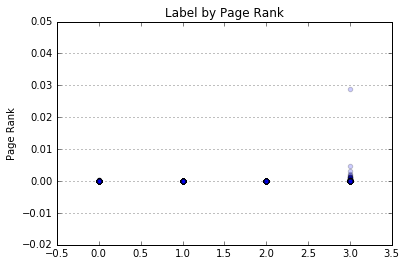

In [42]:
plt.scatter(df.nodetype, df.page_rank, alpha=0.2)
# sets the y axis lable
plt.ylabel("Page Rank")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Label by Page Rank")

There appears to be reasonable variation in these features between the 4 labels given. We test whether this applies to identifying politicians and non politicians.

# Test and Train sets

We had to manually pick out the politicians in the data and create our training and test sets by undersampling the non politicians and oversampling the politicians. We further divided this into 3 experiments.
1. Politicians vs All Nodes ( Officers, Entities, Addresses, Intermediaries )
2. Politicians vs Other officers
3. Politicians vs Other People ( Parsed Dataset of names assumed to be associated with individuals and not any firm )

## Politicians vs All Nodes

In [44]:
df = pd.read_csv('ensemble.csv', low_memory=False)
pol_df = pd.read_csv('data/Politicians.csv', low_memory=False)
id_lst = pol_df['node_id'].tolist()
true_pos = df[df['id'].isin(id_lst)]
true_pos.loc[:,'isPol'] = 1
df = df.drop(df.index[df['id'].isin(id_lst)])
sample = df.sample(frac=0.0003, replace=False)
sample.loc[:,'isPol'] = 0
frames = [true_pos, sample]
data = pd.concat(frames)
data.to_csv('classify-polit-vs-all.csv', index=False)

/Users/ruhi/anaconda2/envs/gl-env/lib/python2.7/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ruhi/anaconda2/envs/gl-env/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Load the dataset

In [47]:
all_people = pd.read_csv("classify-polit-vs-all.csv")
all_people.head()

,id,rec,page_rank,avg_neighbour_deg,cc,out,in_deg,label,isPol
0,15005801,0.0,5.654392e-07,14737.0,0.0,1,0,officers,1
1,15001101,0.0,5.654392e-07,3.0,0.0,3,0,officers,1
2,12018969,0.0,5.654392e-07,203.0,0.0,2,0,officers,1
3,12048878,0.0,5.654392e-07,2.0,0.0,2,0,officers,1
4,12182910,0.0,5.654392e-07,3.0,0.0,3,0,officers,1


In [48]:
import graphlab

In [50]:
nodes = graphlab.SFrame(all_people)
train_data, test_data = nodes.random_split(0.8, seed=0)

This non-commercial license of GraphLab Create for academic use is assigned to ruhi.saraf@colorado.edu and will expire on October 28, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1478998135.log


In [60]:
features = train_data.column_names()
features = features[1:-2]

In [61]:
rm_classifier = graphlab.boosted_trees_classifier.create(train_data, target='isPol',features=[ 'rec','out', 'in_deg', 'avg_neighbour_deg'], validation_set=test_data)

WARNING: Detected extremely low variance for feature(s) 'rec' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 330

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.002107     | 0.857576          | 0.800000            | 0.541567          | 0.563167            |

| 2         | 0.003773     | 0.869697          | 0.752941            | 0.455066          | 0.499526            |

| 3         | 0.005373     | 0.863636          | 0.764706            | 0.396711          | 0.451016            |

| 4         | 0.011626     | 0.875758          | 0.776471            | 0.356360          | 0.417532            |

| 5         | 0.015070     | 0.893939          | 0.729412            | 0.322248          | 0.403965            |

| 6         | 0.016704     | 0.903030          | 0.717647            | 0.299982          | 0.386404            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

## Politicians vs Officers

In [62]:
df = pd.read_csv('ensemble.csv', low_memory=False)
pol_df = pd.read_csv('data/Politicians.csv', low_memory=False)
id_lst = pol_df['node_id'].tolist()
true_pos = df[df['id'].isin(id_lst)]
true_pos.loc[:,'isPol'] = 1
df = df.drop(df.index[df['id'].isin(id_lst)])
df  = df[df['label'] == 'officers']
sample = df.sample(frac=0.0003, replace=False)
sample.loc[:,'isPol'] = 0
frames = [true_pos, sample]
data = pd.concat(frames)
data.to_csv('classify-polit-vs-off.csv', index=False)

### Load the dataset

In [63]:
officers = pd.read_csv("classify-polit-vs-off.csv")
officers.head()

,id,rec,page_rank,avg_neighbour_deg,cc,out,in_deg,label,isPol
0,15005801,0.0,5.654392e-07,14737.0,0.0,1,0,officers,1
1,15001101,0.0,5.654392e-07,3.0,0.0,3,0,officers,1
2,12018969,0.0,5.654392e-07,203.0,0.0,2,0,officers,1
3,12048878,0.0,5.654392e-07,2.0,0.0,2,0,officers,1
4,12182910,0.0,5.654392e-07,3.0,0.0,3,0,officers,1


In [67]:
nodes = graphlab.SFrame(officers)
train_data, test_data = nodes.random_split(0.8, seed=0)

In [68]:
features = train_data.column_names()
features = features[1:-2]

In [69]:
rm_classifier = graphlab.boosted_trees_classifier.create(train_data, target='isPol',features=[ 'rec','out', 'in_deg', 'avg_neighbour_deg'], validation_set=test_data)

WARNING: Detected extremely low variance for feature(s) 'rec' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 181

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.003509     | 0.762431          | 0.666667            | 0.628127          | 0.664378            |

| 2         | 0.006070     | 0.751381          | 0.666667            | 0.596835          | 0.655360            |

| 3         | 0.007428     | 0.751381          | 0.666667            | 0.571077          | 0.643129            |

| 4         | 0.012447     | 0.751381          | 0.666667            | 0.549065          | 0.626411            |

| 5         | 0.014099     | 0.762431          | 0.636364            | 0.529536          | 0.633318            |

| 6         | 0.015432     | 0.767956          | 0.636364            | 0.516984          | 0.633690            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

## Politicians vs Other People ( Presumably )

In [70]:
off_df = pd.read_csv('data/Officers.csv', low_memory=False)
people_node_ids = set()
not_in_lst = ["LTD", "CORP", "TRUST", "GROUP", "???", "BEARER", "LIMITED",
              "FOUND", "HOLDING", "FUND", "@", "INC", "MANAGEMENT", "OVERSEAS",
              "STOCK", "ADMIN"]
while len(people_node_ids) < 100:
    temp = off_df.sample()
    flag = True
    for s in not_in_lst:
        X = temp['name'].values[0]
        if s in X.upper():
            flag = False
            break
    if flag:
        if temp['node_id'].values[0] not in id_lst:
            people_node_ids.add(temp['node_id'].values[0])

off_df = df.ix[df.index[df['id'].isin(people_node_ids)]]
off_df.loc[:,'isPol'] = 0
frames = [true_pos, off_df]
data = pd.concat(frames)
data.to_csv('classify-polit-vs-ppl.csv', index=False)

In [72]:
people = pd.read_csv("classify-polit-vs-ppl.csv")
people.head()

,id,rec,page_rank,avg_neighbour_deg,cc,out,in_deg,label,isPol
0,15005801,0.0,5.654392e-07,14737.0,0.0,1,0,officers,1
1,15001101,0.0,5.654392e-07,3.0,0.0,3,0,officers,1
2,12018969,0.0,5.654392e-07,203.0,0.0,2,0,officers,1
3,12048878,0.0,5.654392e-07,2.0,0.0,2,0,officers,1
4,12182910,0.0,5.654392e-07,3.0,0.0,3,0,officers,1


In [74]:
nodes = graphlab.SFrame(people)
train_data, test_data = nodes.random_split(0.8, seed=0)
features = train_data.column_names()
features = features[1:-2]

In [75]:
rm_classifier = graphlab.boosted_trees_classifier.create(train_data, target='isPol',features=[ 'rec','out', 'in_deg', 'avg_neighbour_deg'], validation_set=test_data)

WARNING: Detected extremely low variance for feature(s) 'rec' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.001920     | 0.803468          | 0.700000            | 0.609944          | 0.633732            |

| 2         | 0.003651     | 0.803468          | 0.700000            | 0.554187          | 0.612084            |

| 3         | 0.005231     | 0.809249          | 0.700000            | 0.520622          | 0.615873            |

| 4         | 0.006963     | 0.815029          | 0.666667            | 0.493917          | 0.620193            |

| 5         | 0.008469     | 0.820809          | 0.666667            | 0.469574          | 0.629532            |

| 6         | 0.009934     | 0.820809          | 0.666667            | 0.452884          | 0.636748            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+